# Investigating double descent

Its been observed with large models, where the number of parameters > number of datapoints, that we dont see the expected rise in test error when we start to overfit.

*   https://openai.com/blog/deep-double-descent/
*   https://medium.com/mlearning-ai/double-descent-8f92dfdc442f
*   https://mlu-explain.github.io/double-descent/
*   https://mlu-explain.github.io/double-descent2/

This is quite confusing... it seems that in some cases we see test performance starts to degrade before getting better again and then surpassing its previous peak performance.
Can we show this happening with simple synthetic data?

I will generate some dummy data of noisy sinusiods and then attempt to overfit to it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets

plt.style.use("seaborn-whitegrid")

Let's generate some random data:

In [157]:
import sklearn.datasets
import sklearn.model_selection

x, y, coef = sklearn.datasets.make_regression(
    n_samples=200,
    n_features=10,
    n_informative=6,
    # n_targets=1,
    # bias=0.0,
    # effective_rank=None,
    # tail_strength=0.5,
    noise=0,
    shuffle=True,
    coef=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x,y, test_size=0.2, random_state=0)

In [172]:
import sklearn.ensemble
import sklearn.metrics

n_estimators = 200
model = sklearn.ensemble.RandomForestRegressor(n_estimators=n_estimators,random_state=0,max_leaf_nodes=200)
model.fit(X_train, y_train)

RandomForestRegressor(max_leaf_nodes=200, n_estimators=200, random_state=0)

In [173]:
def staged_predict(model, X):
    all_preds = []
    for e in model.estimators_:
        all_preds.append(e.predict(X))
    all_preds = np.array(all_preds).transpose()
    all_preds = all_preds.cumsum(axis=1)
    
    all_preds = np.multiply(all_preds, 1/(np.arange(len(model.estimators_))+1))
    return all_preds


train_preds = staged_predict(model, X_train)
train_error = sklearn.metrics.mean_squared_error(np.repeat(y_train[:,np.newaxis],n_estimators,axis=1), train_preds, multioutput='raw_values')

test_preds = staged_predict(model, X_test)
test_error = sklearn.metrics.mean_squared_error(np.repeat(y_test[:,np.newaxis],n_estimators,axis=1), test_preds, multioutput='raw_values')

/var/folders/yq/ddhnc0l57fv0ws1v2qjb0l900000gn/T/ipykernel_28722/1988896467.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


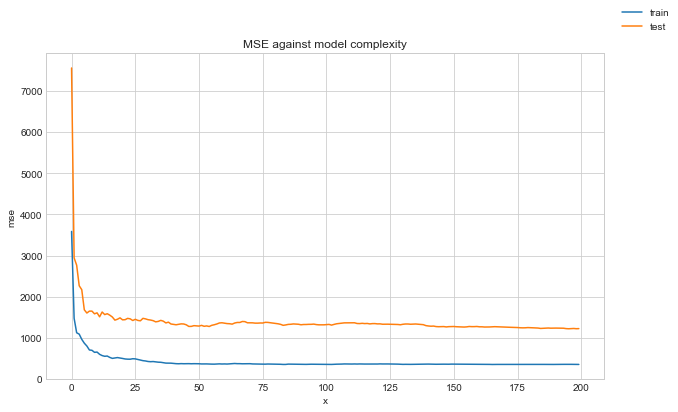

In [174]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(n_estimators), 
    train_error, label='train')
ax.plot(range(n_estimators), 
    test_error, label='test')
ax.set_xlabel("x")
ax.set_ylabel("mse")
ax.set_title("MSE against model complexity")
fig.legend()
fig.show()

In [161]:
n_estimators = 1000
model = sklearn.ensemble.GradientBoostingRegressor(n_estimators=1000,random_state=0, validation_fraction=0, learning_rate=0.05)
model.fit(X_train, y_train)

test_score = []
for y_pred in model.staged_predict(X_test):
    test_score.append(sklearn.metrics.mean_squared_error(y_test, y_pred))
train_score = []
for y_pred in model.staged_predict(X_train):
    train_score.append(sklearn.metrics.mean_squared_error(y_train, y_pred))

/var/folders/yq/ddhnc0l57fv0ws1v2qjb0l900000gn/T/ipykernel_28722/2885235183.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


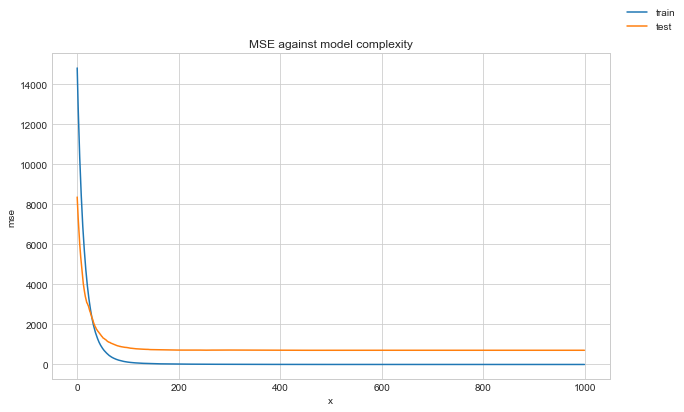

In [162]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(1000), 
    train_score, label='train')
ax.plot(range(1000), 
    test_score, label='test')
ax.set_xlabel("x")
ax.set_ylabel("mse")
ax.set_title("MSE against model complexity")
fig.legend()
fig.show()

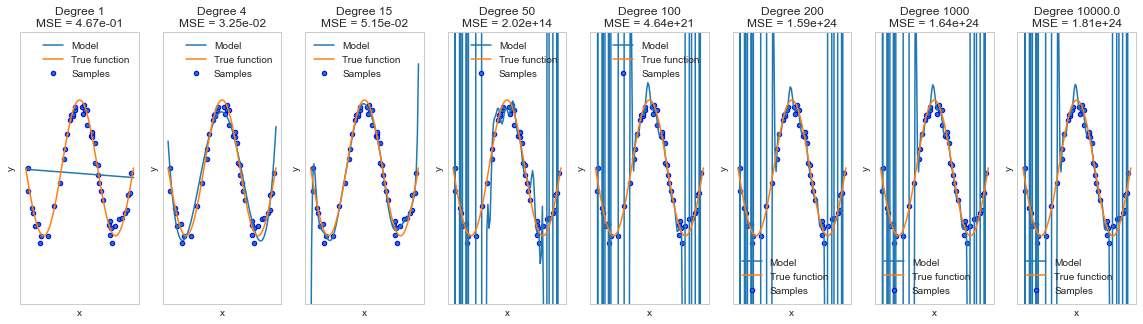

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 50
degrees = [1, 4, 15, 50, 100, 200, 1000, 1e4]
# degrees = range(5, 60)

X_train = np.sort(np.random.rand(n_samples) * 2 - 1)
y_train = true_fun(X_train) + np.random.randn(n_samples) * 0.1

X_test = np.sort(np.random.rand(n_samples) * 2 - 1)
y_test = true_fun(X_test) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(20, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=int(degrees[i]), include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X_train[:, np.newaxis], y_train)

    # Evaluate the models using crossvalidation
    # scores = cross_val_score(
    #     pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    # )
    test_mse = mean_squared_error(y_test, pipeline.predict(X_test[:, np.newaxis]))

    X_plot = np.linspace(-1, 1, 100)
    plt.plot(X_plot, pipeline.predict(X_plot[:, np.newaxis]), label="Model")
    plt.plot(X_plot, true_fun(X_plot), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    # plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}".format(degrees[i], test_mse))
    # plt.title(
    #     "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
    #         degrees[i], -scores.mean(), scores.std()
    #     )
    # )
plt.show()


/var/folders/yq/ddhnc0l57fv0ws1v2qjb0l900000gn/T/ipykernel_28722/2598804761.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


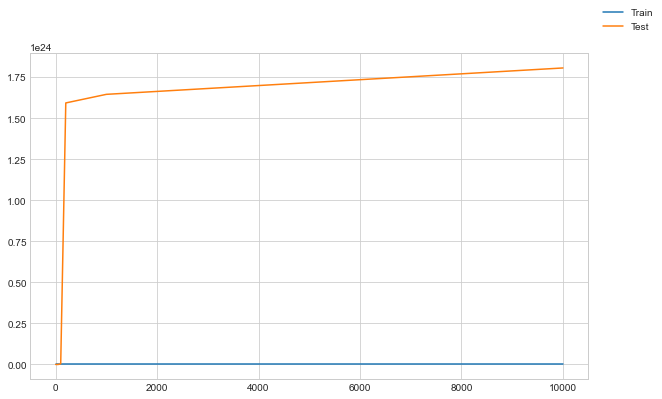

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 50
degrees = [1, 4, 15, 50, 100, 200, 1000, 1e4]
# degrees = range(5, 69)

X_train = np.sort(np.random.rand(n_samples) * 2 - 1)
y_train = true_fun(X_train) + np.random.randn(n_samples) * 0.1

X_test = np.sort(np.random.rand(n_samples) * 2 - 1)
y_test = true_fun(X_test) + np.random.randn(n_samples) * 0.1

train_mse = {}
test_mse = {}
for i in range(len(degrees)):
    polynomial_features = PolynomialFeatures(degree=int(degrees[i]), include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X_train[:, np.newaxis], y_train)

    train_mse[degrees[i]] = mean_squared_error(y_train, pipeline.predict(X_train[:, np.newaxis]))
    test_mse[degrees[i]] = mean_squared_error(y_test, pipeline.predict(X_test[:, np.newaxis]))

fig, ax= plt.subplots(  figsize=(10,6))
ax.plot(train_mse.keys(), train_mse.values(), label='Train')
ax.plot(test_mse.keys(), test_mse.values(), label='Test')
fig.legend()
fig.show()
